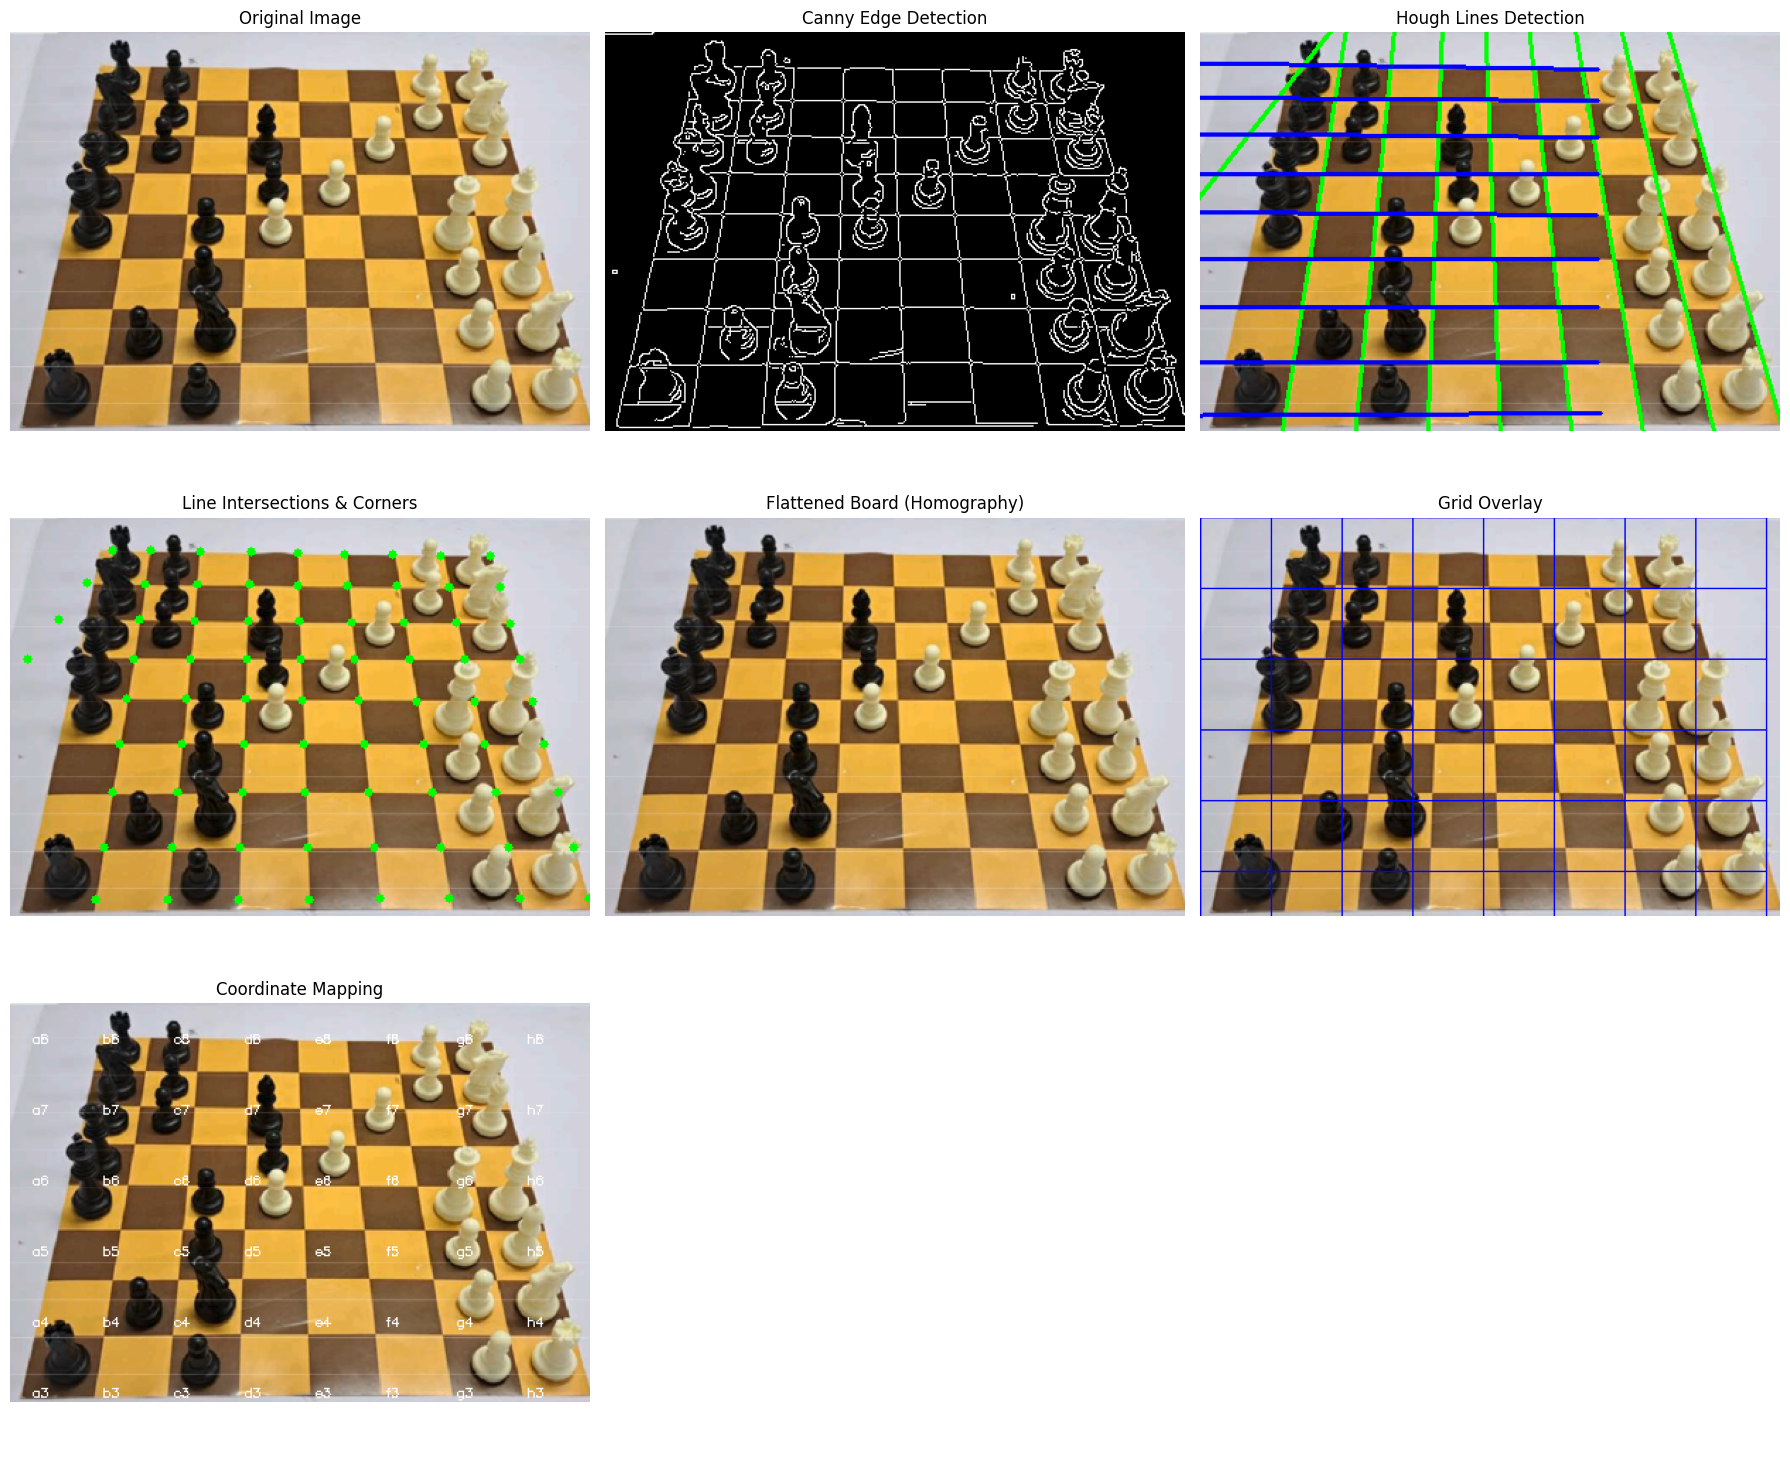

In [42]:
import cv2
import numpy as np
from scipy import ndimage
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

class ChessBoardDetector:
    def __init__(self):
        self.board_corners = None
        self.grid_points = None

    def detect_board_canny(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
        return edges

    def detect_lines_hough(self, edges):
        # Turunkan threshold untuk mendeteksi garis meskipun putus-putus
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)  # Turun dari 145 ke 80
        horizontal_lines = []
        vertical_lines = []

        if lines is not None:
            for line in lines:
                rho, theta = line[0]
                # Klasifikasi horizontal dan vertikal dengan toleransi yang lebih ketat
                if abs(theta) < np.pi/6 or abs(theta - np.pi) < np.pi/6:
                    horizontal_lines.append((rho, theta))
                elif abs(theta - np.pi/2) < np.pi/6:
                    vertical_lines.append((rho, theta))

        return horizontal_lines, vertical_lines

    def detect_lines_hough_probabilistic(self, edges):
        """Alternative menggunakan HoughLinesP untuk deteksi segment garis"""
        # Probabilistic Hough Line Transform
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=250)

        horizontal_lines = []
        vertical_lines = []

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Hitung sudut garis
                angle = np.arctan2(y2 - y1, x2 - x1)

                # Konversi ke format rho, theta
                if abs(angle) < np.pi/6 or abs(angle - np.pi) < np.pi/6 or abs(angle + np.pi) < np.pi/6:
                    # Horizontal line
                    rho = abs(y1 * np.cos(np.pi/2) + x1 * np.sin(np.pi/2))
                    theta = np.pi/2 if y1 > 0 else -np.pi/2
                    horizontal_lines.append((rho, theta))
                elif abs(angle - np.pi/2) < np.pi/6 or abs(angle + np.pi/2) < np.pi/6:
                    # Vertical line
                    rho = abs(x1 * np.cos(0) + y1 * np.sin(0))
                    theta = 0
                    vertical_lines.append((rho, theta))

        return horizontal_lines, vertical_lines

    def detect_board_canny_minimal(self, image):
        """Preprocessing minimal untuk fokus ke deteksi garis"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Hanya blur ringan
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # Canny dengan threshold lebih rendah
        edges = cv2.Canny(blurred, 30, 90, apertureSize=3)

        return edges

    def cluster_lines(self, lines, tolerance=30):
        if not lines:
            return []

        rhos = np.array([line[0] for line in lines]).reshape(-1, 1)
        clustering = DBSCAN(eps=tolerance, min_samples=1).fit(rhos)

        clustered_lines = []
        for cluster_id in set(clustering.labels_):
            cluster_lines = [lines[i] for i in range(len(lines)) if clustering.labels_[i] == cluster_id]
            avg_rho = np.mean([line[0] for line in cluster_lines])
            avg_theta = np.mean([line[1] for line in cluster_lines])
            clustered_lines.append((avg_rho, avg_theta))

        return sorted(clustered_lines, key=lambda x: x[0])

    def line_intersections(self, h_lines, v_lines):
        intersections = []

        for h_rho, h_theta in h_lines:
            for v_rho, v_theta in v_lines:
                A = np.array([[np.cos(h_theta), np.sin(h_theta)],
                             [np.cos(v_theta), np.sin(v_theta)]])
                b = np.array([h_rho, v_rho])

                try:
                    point = np.linalg.solve(A, b)
                    intersections.append((int(point[0]), int(point[1])))
                except np.linalg.LinAlgError:
                    continue

        return intersections

    def detect_board_corners(self, intersections, image_shape):
        if len(intersections) < 4:
            return None

        points = np.array(intersections)

        # Find bounding box corners
        min_x, min_y = np.min(points, axis=0)
        max_x, max_y = np.max(points, axis=0)

        corners = []
        tolerance = 50

        # Top-left
        top_left_candidates = points[(points[:, 0] <= min_x + tolerance) & 
                                   (points[:, 1] <= min_y + tolerance)]
        if len(top_left_candidates) > 0:
            corners.append(tuple(top_left_candidates[0]))

        # Top-right
        top_right_candidates = points[(points[:, 0] >= max_x - tolerance) & 
                                    (points[:, 1] <= min_y + tolerance)]
        if len(top_right_candidates) > 0:
            corners.append(tuple(top_right_candidates[-1]))

        # Bottom-left
        bottom_left_candidates = points[(points[:, 0] <= min_x + tolerance) & 
                                      (points[:, 1] >= max_y - tolerance)]
        if len(bottom_left_candidates) > 0:
            corners.append(tuple(bottom_left_candidates[0]))

        # Bottom-right
        bottom_right_candidates = points[(points[:, 0] >= max_x - tolerance) & 
                                       (points[:, 1] >= max_y - tolerance)]
        if len(bottom_right_candidates) > 0:
            corners.append(tuple(bottom_right_candidates[-1]))

        if len(corners) == 4:
            return np.array(corners, dtype=np.float32)

        return None

    def apply_homography(self, image, corners):
        if corners is None:
            return image

        # Sort corners: top-left, top-right, bottom-right, bottom-left
        rect = np.zeros((4, 2), dtype=np.float32)
        s = corners.sum(axis=1)
        rect[0] = corners[np.argmin(s)]  # top-left
        rect[2] = corners[np.argmax(s)]  # bottom-right

        diff = np.diff(corners, axis=1)
        rect[1] = corners[np.argmin(diff)]  # top-right
        rect[3] = corners[np.argmax(diff)]  # bottom-left

        # Define destination points for 400x400 square
        dst = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype=np.float32)

        # Compute homography matrix
        M = cv2.getPerspectiveTransform(rect, dst)

        # Apply perspective transformation
        flattened = cv2.warpPerspective(image, M, (400, 400))

        return flattened

    def generate_grid_coordinates(self, size=400):
        coords = {}
        files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        ranks = ['8', '7', '6', '5', '4', '3', '2', '1']

        square_size = size // 8

        for i in range(8):
            for j in range(8):
                file_name = files[j]
                rank_name = ranks[i]
                square_name = file_name + rank_name

                x = j * square_size + square_size // 2
                y = i * square_size + square_size // 2

                coords[square_name] = (x, y)

        return coords

    def process_image(self, image_path):
        # Load image
        image = cv2.imread(image_path)
        original_image = image.copy()

        # Step 1: Minimal Edge Detection
        edges = self.detect_board_canny_minimal(image)

        # Step 2: Hough Line Transform dengan threshold rendah
        h_lines, v_lines = self.detect_lines_hough(edges)

        # Alternative: coba juga dengan Probabilistic Hough
        h_lines_prob, v_lines_prob = self.detect_lines_hough_probabilistic(edges)

        # Gabungkan hasil dari kedua metode
        h_lines.extend(h_lines_prob)
        v_lines.extend(v_lines_prob)

        # Cluster similar lines dengan toleransi yang lebih ketat
        h_lines = self.cluster_lines(h_lines, tolerance=20)  # Turun dari 30 ke 20
        v_lines = self.cluster_lines(v_lines, tolerance=20)

        # Filter hanya garis yang paling kuat (opsional)
        h_lines = self.filter_strongest_lines(h_lines, max_lines=9)
        v_lines = self.filter_strongest_lines(v_lines, max_lines=9)

        # Draw detected lines
        lines_overlay = self.draw_lines(image, h_lines, v_lines)

        # Step 3: Line Intersections
        intersections = self.line_intersections(h_lines, v_lines)

        # Detect board corners
        corners = self.detect_board_corners(intersections, image.shape)

        # Step 4: Homography transformation
        flattened_board = self.apply_homography(image, corners)

        # Generate grid coordinates
        grid_coords = self.generate_grid_coordinates()

        return {
            'original': original_image,
            'edges': edges,
            'lines_overlay': lines_overlay,
            'intersections': intersections,
            'corners': corners,
            'flattened': flattened_board,
            'grid_coordinates': grid_coords
        }

    def filter_strongest_lines(self, lines, max_lines=9):
        """Filter untuk mengambil garis yang paling kuat saja"""
        if len(lines) <= max_lines:
            return lines

        # Untuk sementara, ambil yang terdistribusi merata
        # Bisa diperbaiki dengan menambah scoring berdasarkan kekuatan edge
        if len(lines) > max_lines:
            # Ambil yang terdistribusi merata
            indices = np.linspace(0, len(lines)-1, max_lines, dtype=int)
            return [lines[i] for i in indices]

        return lines

    def draw_lines(self, image, h_lines, v_lines):
        line_image = image.copy()
        height, width = image.shape[:2]

        # Draw horizontal lines
        for rho, theta in h_lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + width * (-b))
            y1 = int(y0 + width * (a))
            x2 = int(x0 - width * (-b))
            y2 = int(y0 - width * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw vertical lines
        for rho, theta in v_lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + height * (-b))
            y1 = int(y0 + height * (a))
            x2 = int(x0 - height * (-b))
            y2 = int(y0 - height * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        return line_image

    def visualize_results(self, results):
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        axes = axes.ravel()

        # Original image
        axes[0].imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Edge detection
        axes[1].imshow(results['edges'], cmap='gray')
        axes[1].set_title('Canny Edge Detection')
        axes[1].axis('off')

        # Line detection overlay
        axes[2].imshow(cv2.cvtColor(results['lines_overlay'], cv2.COLOR_BGR2RGB))
        axes[2].set_title('Hough Lines Detection')
        axes[2].axis('off')

        # Intersections
        img_intersections = results['original'].copy()
        for point in results['intersections']:
            cv2.circle(img_intersections, point, 3, (0, 255, 0), -1)
        if results['corners'] is not None:
            for corner in results['corners']:
                cv2.circle(img_intersections, tuple(corner.astype(int)), 8, (0, 0, 255), -1)

        axes[3].imshow(cv2.cvtColor(img_intersections, cv2.COLOR_BGR2RGB))
        axes[3].set_title('Line Intersections & Corners')
        axes[3].axis('off')

        # Flattened board
        if results['flattened'] is not None:
            axes[4].imshow(cv2.cvtColor(results['flattened'], cv2.COLOR_BGR2RGB))
            axes[4].set_title('Flattened Board (Homography)')
            axes[4].axis('off')

            # Grid overlay on flattened board
            grid_overlay = results['flattened'].copy()
            for i in range(9):
                cv2.line(grid_overlay, (i*50, 0), (i*50, 400), (255, 0, 0), 1)
                cv2.line(grid_overlay, (0, i*50), (400, i*50), (255, 0, 0), 1)

            axes[5].imshow(cv2.cvtColor(grid_overlay, cv2.COLOR_BGR2RGB))
            axes[5].set_title('Grid Overlay')
            axes[5].axis('off')

            # Coordinate mapping
            coord_overlay = results['flattened'].copy()
            files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
            ranks = ['8', '7', '6', '5', '4', '3', '2', '1']

            for i in range(8):
                for j in range(8):
                    square_name = files[j] + ranks[i]
                    x, y = results['grid_coordinates'][square_name]
                    cv2.putText(coord_overlay, square_name, (x-10, y+3), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

            axes[6].imshow(cv2.cvtColor(coord_overlay, cv2.COLOR_BGR2RGB))
            axes[6].set_title('Coordinate Mapping')
            axes[6].axis('off')

        # Hide unused subplots
        for i in range(7, 9):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

# Usage
detector = ChessBoardDetector()
results = detector.process_image('chessboard2.png')  # Ganti dengan path gambar Anda
detector.visualize_results(results)

# Akses koordinat grid
grid_coordinates = results['grid_coordinates']